<h1><strong>Downsampling Experiment</strong></h1>

In [2]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

<h2>Load Model</h2>

In [ ]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [59]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda
Channels : 24


In [4]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_278423/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h2>Load others models</h2>

In [32]:
# Evaluate other model
from utils import ACTIVATIONS
import utils
importlib.reload(utils)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
'''
#Giddy Pond
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    #"activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128, 256, 512, 1024],
'attention_levels' : [4],
'hidden_blocks' : [2,3,3,3,3],
'spatial' : 2,
'channels' : 24,
'context' : 5,
'embedding' : 64}

# Bumbling Snow
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
   # "activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [2,3,4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 128
}

# Fast Silence 89 -> DateEmbedding(x=8, y=8, hidden_dim=32, num_layers=3)
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 128,
    "eta": 5e-3,
    'x' : 64,
    'y' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 128,
    "activation": ACTIVATIONS['SiLU'],
}

# elated deluge 92 -> Construct Naive Context
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 1,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 128,
    "eta": 5e-3,
    'x' : 64,
    'y' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 8,
    'embedding': 128,
    "activation": ACTIVATIONS['SiLU'],
}'
''' 
# Revivded Glade 93 -> DateEmbedding() 
TRAIN_CONFIG = {
        "window" : 12,
        "epochs": 10000,
        "batch_size": 1,
        "learning_rate": 2e-4,
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "embedding": 512,
        "eta": 5e-3,
    }
MODEL_CONFIG = {
    'hidden_channels': [128,128,256,384,512],
    'attention_levels': [4],
    'hidden_blocks': [3,3,3,3,3],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 512,
    "activation": ACTIVATIONS['SiLU'],
    'x' : 64,
    'y' : 64
}
# x=8,y=8, hidden_dim=32, num_layers=3
#date_embedding_args = {'x': 8, 'y': 8, 'hidden_dim': 32, 'num_layers': 3}
date_embedding_args = {}
CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
path_data = 'data/processed'
#path_model = 'checkpoints/bumbling-snow-84_2nueyyzk/model_160.pth' 
#path_model = 'checkpoints/fast-silence-89_coqy9s8u/model_10.pth'
#path_model = 'checkpoints/elated-deluge-92_vwboono4/model_70.pth'
path_model = 'checkpoints/revived-glade-93_b1ergcxy/model_130.pth'
PATH_DATA = Path('./data/processed')
giddy_pond_setup = utils.load_setup(CONFIG, path_data, path_model, device, date_embedding=True, multi_gpu=True, date_embedding_args=date_embedding_args)

Using device: cuda


/home/mtemoschenko/TFE/utils.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  date_embedding.eval()


Loaded Date Embedding
Model restored from checkpoints/revived-glade-93_b1ergcxy/model_130.pth, trained until epoch 130


In [33]:
testloader, vpsde, mask, mask_cpu = giddy_pond_setup['validloader'], giddy_pond_setup['vpsde'], giddy_pond_setup['mask'], giddy_pond_setup['mask_cpu']

<h2> A(x_(x(t)) </h2>

In [44]:

def downscale(batch, mask, patch_size, device='cpu'):
    if batch.shape[1] == 1 and batch.dim() == 5:
        #print(f"heheh : {batch.shape}")
        batch = batch.squeeze(1)
    #print(f"batch : {batch.shape}")
    B1, B2, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    patches = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B1, B2, new_H, new_W, patch_size, patch_size)
    #print(mask.shape)
    myMask = mask[0]
    mask_patches = myMask.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    #print(patches.shape)
    #print(mask_patches.shape)
    valid_patches = patches * mask_patches.unsqueeze(0).unsqueeze(0)
    valid_counts = mask_patches.sum(dim=(-2, -1), keepdim=True)
    
    valid_counts = torch.where(valid_counts == 0, torch.tensor(1, device=device), valid_counts)
    downscaled_grid = valid_patches.sum(dim=(-2, -1)) / valid_counts.squeeze(-1).squeeze(-1)
    downscaled_mask = mask_patches.any(dim=(-2, -1))
    #print(downscaled_mask.shape)
    
    upsampled_batch = downscaled_grid.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_mask = downscaled_mask.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_batch = upsampled_batch * mask
    return upsampled_batch
def downscale_no_upsample(batch, mask=None, patch_size=16, device='cpu'):
    if batch.shape[1] == 1 and batch.dim() == 5:
        batch = batch.squeeze(1)
    
    B1, B2, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    patches = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B1, B2, new_H, new_W, patch_size, patch_size)
    
    if mask is not None:
        if isinstance(mask, list):
            mask = mask[0]
        mask = mask[0]
        mask_patches = mask.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
        valid_patches = patches * mask_patches.unsqueeze(0).unsqueeze(0)
        valid_counts = mask_patches.sum(dim=(-2, -1), keepdim=True)
        valid_counts = torch.where(valid_counts == 0, torch.tensor(1, device=device), valid_counts)
        downscaled_grid = valid_patches.sum(dim=(-2, -1)) / valid_counts.squeeze(-1).squeeze(-1)
    else:
        # If no mask is provided, simply average all patches
        downscaled_grid = patches.mean(dim=(-2, -1))
    
    return downscaled_grid  # Shape: (B1, B2, new_H, new_W)
def upsample_to_64x64(downscaled_grid, mask=None, device='cpu'):
    """
    Upsamples a downscaled grid to 64x64 resolution.
    
    Args:
        downscaled_grid (torch.Tensor): Input tensor of shape (B1, B2, H, W)
        mask (torch.Tensor, optional): Mask to apply to the upsampled grid
        device (str): Device to use for tensor operations
        
    Returns:
        torch.Tensor: Upsampled tensor of shape (B1, B2, 64, 64)
    """
    B1, B2, H, W = downscaled_grid.shape
    
    # Calculate scale factors needed to reach 64x64
    scale_h = 64 // H
    scale_w = 64 // W
    
    # Check if we need to adjust for non-divisible dimensions
    pad_h = 64 - (H * scale_h)
    pad_w = 64 - (W * scale_w)
    
    # Upsample using repeat_interleave (nearest neighbor)
    upsampled = downscaled_grid.repeat_interleave(scale_h, dim=2).repeat_interleave(scale_w, dim=3)
    
    # If padding is needed, add it
    if pad_h > 0 or pad_w > 0:
        upsampled = torch.nn.functional.pad(upsampled, (0, pad_w, 0, pad_h))
    
    # Apply mask if provided
    if mask is not None:
        if isinstance(mask, list):
            mask = mask[0]
        # Ensure mask is 64x64
        if mask.shape != (64, 64):
            # Resize mask if needed
            mask_64x64 = torch.nn.functional.interpolate(
                mask.unsqueeze(0).unsqueeze(0).float(), 
                size=(64, 64), 
                mode='nearest'
            ).squeeze(0).squeeze(0).bool()
        else:
            mask_64x64 = mask
        
        upsampled = upsampled * mask_64x64.to(device)
    
    return upsampled

In [36]:
batch, dic = next(iter(testloader))
batch = batch.cpu()
new_tensor = torch.stack((batch,downscale(batch,mask_cpu,8)), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
# fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)


In [64]:
def A(x):
    #return downscale(x,mask,16)
    return downscale_no_upsample(x,mask,16)
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)
y_star = torch.normal(A(x_star), 1e-3)

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
# fig = plot_sample(y_star.detach().cpu(),info,mask_cpu,samples=1,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1><bold>Visualization of Experience </bold> </h1>

In [65]:
x_star, dic_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = utils.constructEmbedding(giddy_pond_setup['date_embedding'], dic_star).to(device)
y_star = torch.normal(A(x_star), 1e-3)
print(f"x_star : {x_star.shape}")
print(f"c_star : {c_star.shape}")
print(f"y_star : {y_star.shape}")

x_star : torch.Size([1, 24, 64, 64])
c_star : torch.Size([1, 5, 64, 64])
y_star : torch.Size([1, 24, 4, 4])


In [75]:
importlib.reload(score)
#sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=4.7), shape=x_star.shape).cuda()
sde = VPSDE(score.GaussianScore(y_star, mask, A=A, std=1e-3, sde=vpsde, gamma=0.02), shape=x_star.shape).cuda()

# Some params for Raw Gaussian Score
# gamme = 0.1, steps = 256, corrections = 2 with std=1e-3

In [76]:
num_samples = 10
x = sde.sample(mask,shape=(num_samples,), c=c_star[0].squeeze(0), steps=256, corrections=2, tau=0.5).cpu()


100%|█████████████████████████████████████████████████| 256/256 [01:01<00:00,  4.15it/s]


torch.Size([12, 24, 64, 64])
T2m  Mean : 7.322572231292725, Var: 0.8743890523910522
U10m  Mean : 2.242713212966919, Var: 0.7152820229530334
T2m  Mean : 7.322799205780029, Var: 0.7809359431266785
U10m  Mean : 2.242828130722046, Var: 0.5275446176528931
T2m  Mean : 7.320644378662109, Var: 0.9274201989173889
U10m  Mean : 2.243058919906616, Var: 0.7929043769836426
T2m  Mean : 7.32002592086792, Var: 0.9171714186668396
U10m  Mean : 2.2426493167877197, Var: 0.7994779944419861
T2m  Mean : 7.317872047424316, Var: 0.8922404646873474
U10m  Mean : 2.2427027225494385, Var: 0.7997707724571228
T2m  Mean : 7.322683811187744, Var: 0.8794130682945251
U10m  Mean : 2.242581844329834, Var: 0.8370633125305176
T2m  Mean : 7.320699691772461, Var: 0.8777328729629517
U10m  Mean : 2.2432119846343994, Var: 0.8010316491127014
T2m  Mean : 7.319705009460449, Var: 0.9390867948532104
U10m  Mean : 2.243245840072632, Var: 0.7865657210350037
T2m  Mean : 7.322744846343994, Var: 0.8882967233657837
U10m  Mean : 2.24340057373

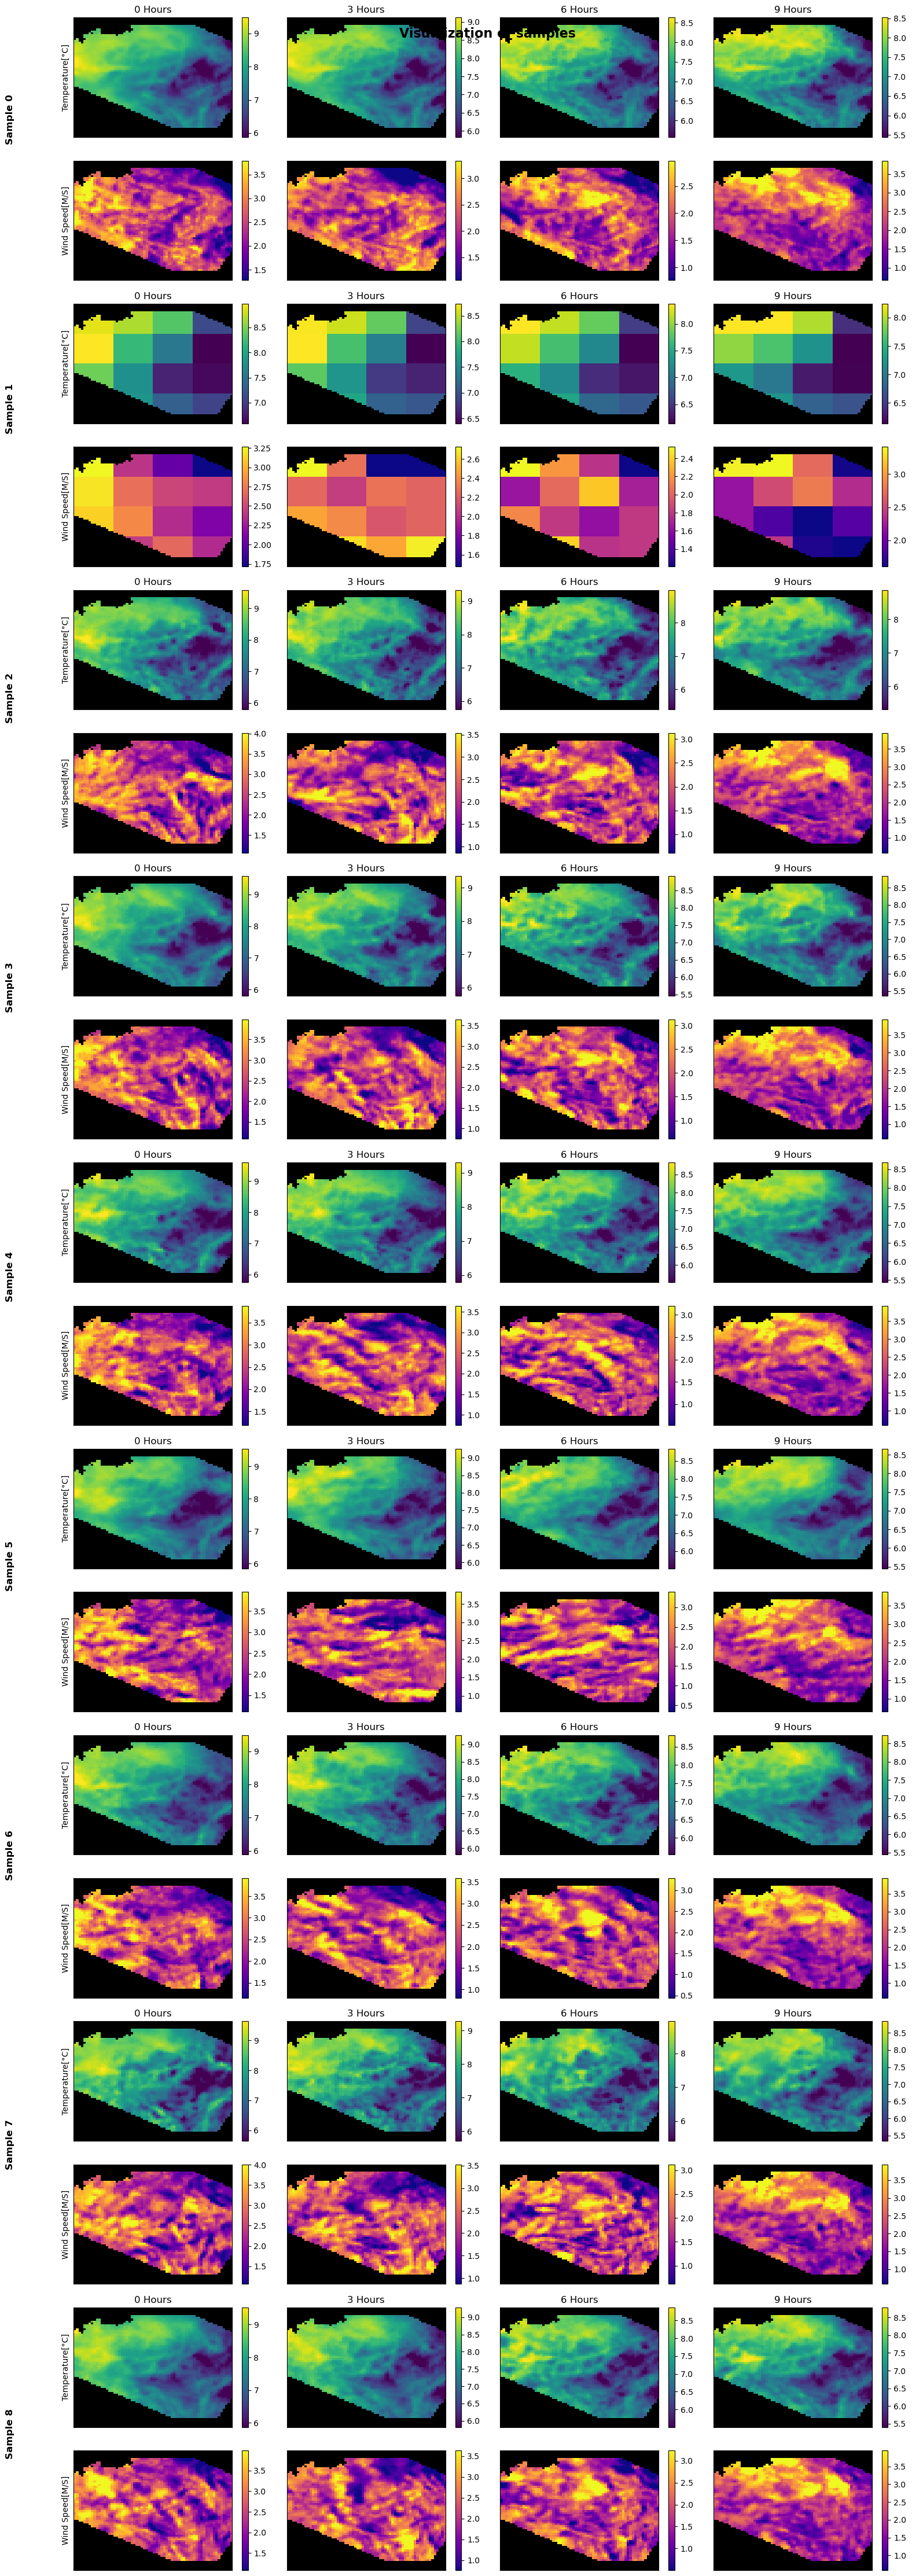

In [77]:
import utils 
importlib.reload(utils)
x_ = x.squeeze(1)
# Good parameters : zeta: 4.5, steps: 48, corrections: 3
# zeta= 4.7, steps = 64, corrections = 8, tau = 0.5
# new_tensor = torch.cat([x_star.detach().cpu(),y_star.detach().cpu(),x_.detach().cpu()])
y_star_upsample = upsample_to_64x64(y_star.cpu(), mask_cpu[0])
new_tensor = torch.cat([x_star.detach().cpu(),y_star_upsample,x_.detach().cpu()])
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = utils.plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)
plt.show()

In [29]:
# Inspect Extreme values 
max_val = x[0,0].max().item()
min_val = x[0,0].min().item()
mean_val = x[0,0].mean().item()
print(f"Max: {max_val}, Min: {min_val}, Mean: {mean_val}, Std : {x[0,0].std().item()}")

# Find indices of extreme values
threshold = mean_val + 3 * x[0,0].std().item()
extreme_indices = torch.where(x[0,0]> threshold)
print(f"Extreme values at: {extreme_indices}")

Max: 80.80831146240234, Min: -5.1142377853393555, Mean: -0.06899648904800415, Std : 0.821622908115387
Extreme values at: (tensor([ 0,  1,  3,  4,  5,  6,  7,  7,  7,  9,  9,  9,  9,  9, 11, 11, 11, 12,
        13, 15, 17, 18, 19, 21, 23]), tensor([ 7,  7,  7,  7,  7,  7,  7, 40, 44,  7, 39, 39, 41, 42,  7, 21, 22,  7,
         7,  7,  7,  7,  7,  7,  7]), tensor([ 7,  7,  7,  7,  7,  7,  7,  7, 19,  7, 10, 11, 24, 20,  7, 11, 11,  7,
         7,  7,  7,  7,  7,  7,  7]))


In [62]:
import utils
importlib.reload(utils)
x_ = x.squeeze(1)
wavelengths_x_star, radii,  avg_rapsd_x_star, channel_rapsds = utils.compute_rapsd(x_star, 5)
wavelengths_x_, _, avg_rapsd_x_, _ = utils.compute_rapsd(x_, 5)
wavelengths_y_star, _, avg_rapsd_y_star, _ = utils.compute_rapsd(y_star, 5)

In [58]:
print(f"avg_rapsd_x_star : {avg_rapsd_x_star.shape}, avg_rapsd_x_ : {avg_rapsd_x_.shape}, avg_rapsd_y_star : {avg_rapsd_y_star.shape}")

avg_rapsd_x_star : (1, 2, 1, 32), avg_rapsd_x_ : (10, 2, 1, 32), avg_rapsd_y_star : (1, 2, 1, 1)


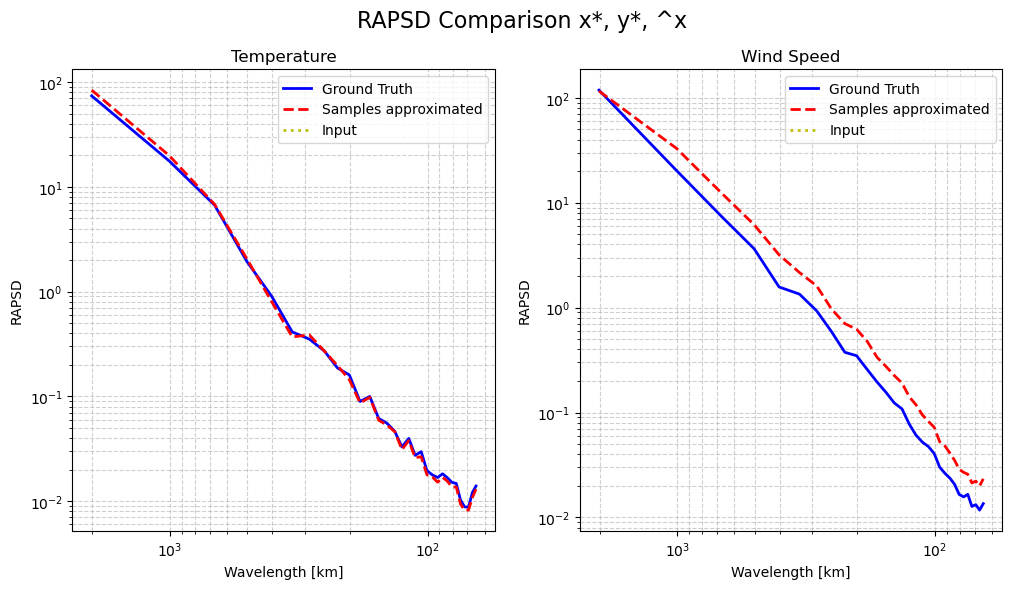

In [63]:
channel_names = ["Temperature", "Wind Speed"]
title =  f"RAPSD Comparison x*, y*, ^x"
figsize  = (12, 6)
fig, axes = plt.subplots(1, len(channel_names), figsize=figsize)
if len(channel_names) == 1:
    axes = np.array([axes])

#mean_rapsd_x_star = np.mean(avg_rapsd_x_star.squeeze(2), axis=0)
mean_rapsd_x_ = np.mean(avg_rapsd_x_.squeeze(2), axis=0)
#mean_rapsd_y_star = np.mean(avg_rapsd_y_star.squeeze(2), axis=0)
for i, name in enumerate(channel_names):
    ax = axes[i]
    ax.loglog(wavelengths_x_star, avg_rapsd_x_star.squeeze(2)[0][i], 'b-', label='Ground Truth', linewidth=2)
    ax.loglog(wavelengths_x_, mean_rapsd_x_[i], 'r--', label='Samples approximated', linewidth=2)
    ax.loglog(wavelengths_y_star, avg_rapsd_y_star.squeeze(2)[0][i], 'y:', label='Input', linewidth=2)
    ax.xaxis.set_inverted(True)
    ax.set_xlabel('Wavelength [km]')
    ax.set_ylabel('RAPSD')
    ax.set_title(name)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# Add overall figure title
fig.suptitle(title, fontsize=16)
# Add space for the title

plt.show()

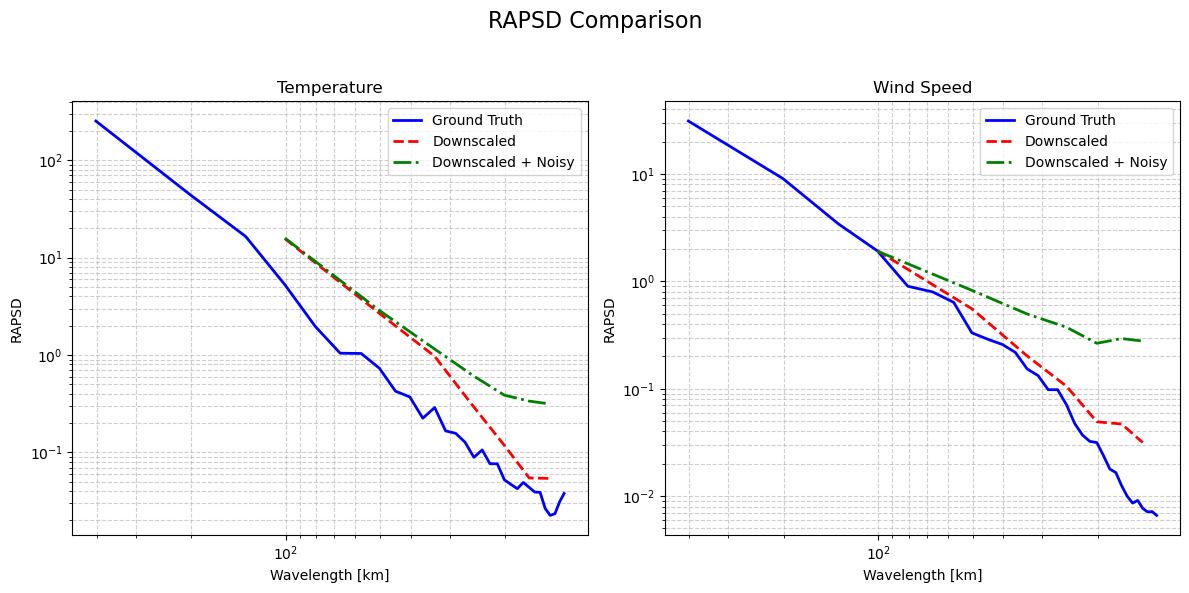

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_sample, compute_rapsd

# Assuming x_star, y_star, and x_ are defined elsewhere in your code
x_ = x.squeeze(1).detach().cpu()
x_star = x_star.detach().cpu()

# Adjusted downscaling method
def downscale_average(batch, patch_size):
    B, C, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    downscaled = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    downscaled = downscaled.contiguous().view(B, C, new_H, new_W, patch_size, patch_size)
    downscaled = downscaled.mean(dim=(-1, -2))
    return downscaled

# Downscale the data using averaging
patch_size = 4  # Adjust this factor as needed
downscaled_data = downscale_average(x_star, patch_size)

# Add increased noise to the downscaled data
noise_level = 0.5  # Increased noise level
noisy_downscaled_data = downscaled_data + noise_level * torch.randn_like(downscaled_data)

# Compute RAPSD for the ground truth, downscaled, and noisy data
resolution_km = 1.0  # Adjust this value as needed
wavelengths_gt, radii_gt, avg_rapsd_batch_gt, _ = compute_rapsd(x_star, resolution_km)
wavelengths_ds, radii_ds, avg_rapsd_batch_ds, _ = compute_rapsd(downscaled_data, resolution_km)
wavelengths_nd, radii_nd, avg_rapsd_batch_nd, _ = compute_rapsd(noisy_downscaled_data, resolution_km)

# 

mean_rapsd_batch_gt = np.mean(avg_rapsd_batch_gt.squeeze(2), axis=0)[:min_length]
mean_rapsd_batch_ds = np.mean(avg_rapsd_batch_ds.squeeze(2), axis=0)[:min_length]
mean_rapsd_batch_nd = np.mean(avg_rapsd_batch_nd.squeeze(2), axis=0)[:min_length]

# Plot RAPSD
channel_names = ["Temperature", "Wind Speed"]
title = "RAPSD Comparison"
figsize = (12, 6)
fig, axes = plt.subplots(1, len(channel_names), figsize=figsize)
if len(channel_names) == 1:
    axes = np.array([axes])

for i, name in enumerate(channel_names):
    ax = axes[i]
    ax.loglog(wavelengths_gt, mean_rapsd_batch_gt[i], 'b-', label='Ground Truth', linewidth=2)
    ax.loglog(wavelengths_ds, mean_rapsd_batch_ds[i], 'r--', label='Downscaled', linewidth=2)
    ax.loglog(wavelengths_nd, mean_rapsd_batch_nd[i], 'g-.', label='Downscaled + Noisy', linewidth=2)
    ax.xaxis.set_inverted(True)
    ax.set_xlabel('Wavelength [km]')
    ax.set_ylabel('RAPSD')
    ax.set_title(name)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# Add overall figure title
fig.suptitle(title, fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [50]:
print(downscaled_data.shape)

torch.Size([1, 24, 16, 16])
